In [111]:
import geopandas as gp
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape, JOIN_STYLE


In [2]:
cm = gp.read_file("../shape/Crop__Mapping_2014.shp")
cvsa = gp.read_file("../shape/cv.shp")
crs = {"init":"epsg:4326"}
cvsa.crs = crs

def explode(gdf):
    """    
    Will explode the geodataframe's muti-part geometries into single 
    geometries. Each row containing a multi-part geometry will be split into
    multiple rows with single geometries, thereby increasing the vertical size
    of the geodataframe. The index of the input geodataframe is no longer
    unique and is replaced with a multi-index. 

    The output geodataframe has an index based on two columns (multi-index) 
    i.e. 'level_0' (index of input geodataframe) and 'level_1' which is a new
    zero-based index for each single part geometry per multi-part geometry

    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries

    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with each single 
                                 geometry as a separate entry in the 
                                 geodataframe. The GeoDataFrame has a multi-
                                 index set to columns level_0 and level_1

    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out

In [ ]:
list(cm)

In [3]:
# Bar plot of of acreage by crop type in 2014
out = {}

for i in cm.DWR_Standa.unique():
    acreage = cm[cm.DWR_Standa == i]['Acres'].sum()
    out[i] = acreage*0.00404686 # acres to sq km

In [4]:
total = np.array(list(out.values())).sum()

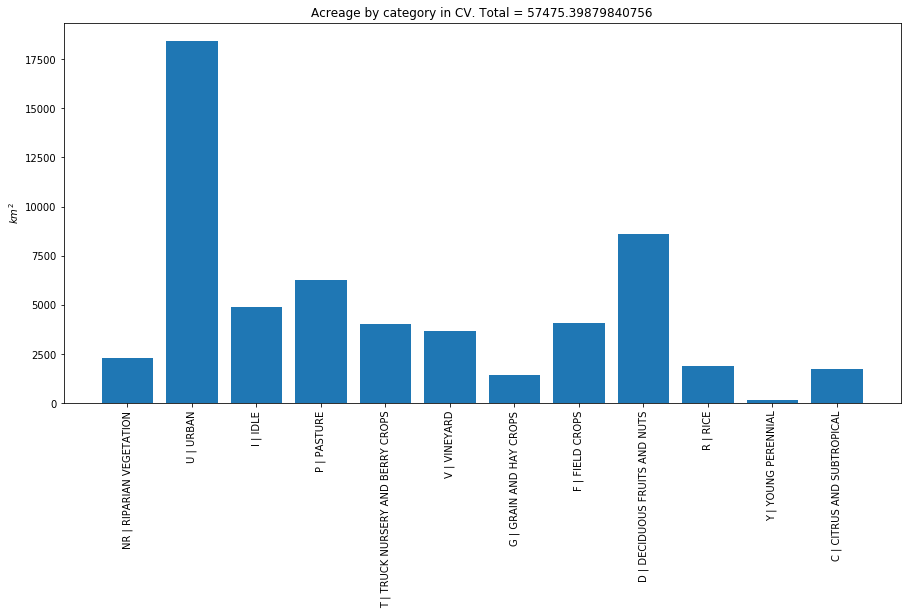

In [9]:
plt.figure(figsize=(15,7))
plt.bar(range(len(out)), out.values(), align='center')
plt.title("Acreage by category in CV. Total = {}".format(str(total)))
plt.xticks(range(len(out)), list(out.keys()),rotation='vertical')
plt.ylabel("$km^2$")
plt.show()

In [84]:
irr_dfs = []

for i in list(cm.DWR_Standa.unique())[4:6]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[7:]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    irr_dfs.append(within_cv)

T | TRUCK NURSERY AND BERRY CROPS
V | VINEYARD
F | FIELD CROPS
D | DECIDUOUS FRUITS AND NUTS
R | RICE
Y | YOUNG PERENNIAL
C | CITRUS AND SUBTROPICAL


In [ ]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(1, 1, 1)
cvsa.plot(ax=ax, color = "blue", alpha = 0.1)

for i in range(len(irr_dfs)):
    irr_dfs[i].plot(ax=ax)
    
plt.show()

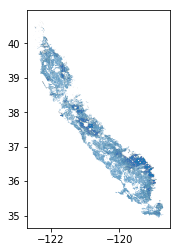

In [92]:
dfs = pd.concat(irr_dfs)
# test = dfs.dissolve(by = "DWR_Standa")
t = explode(dfs)
t.plot()

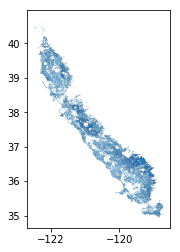

In [102]:
t = dfs.convex_hull
t.plot()

In [128]:
eps = 0.1
t = dfs.buffer(eps).buffer(-eps)

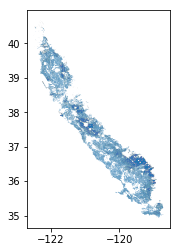

In [141]:
temp = gp.GeoDataFrame(dfs.buffer(0.05))


,0
1551,POLYGON ((-119.2132106669968 35.71544800729791...
1552,POLYGON ((-119.3708411629902 35.69441989220441...
1555,POLYGON ((-119.8911022119895 35.68106502245662...
1556,POLYGON ((-119.9089641102734 35.72211353443652...
1649,POLYGON ((-119.1465644490073 35.38166006325729...
1712,POLYGON ((-118.8832030360161 34.91774652831216...
1755,POLYGON ((-118.7989096336209 35.21839777948929...
1756,POLYGON ((-118.7921210097065 35.19241905303257...
1757,POLYGON ((-118.7921290185807 35.18980180047443...
2103,"POLYGON ((-121.5686947628693 38.9872306113898,..."


In [166]:
t = dfs.buffer(0.001).unary_union

In [ ]:
t2 = t.buffer(-0.002)

In [ ]:
fin_df = gp.GeoDataFrame(geometry=gp.GeoSeries(t2))

In [ ]:
fin_df.plot()

In [162]:
fin_df.to_file("../shape/test3.shp")

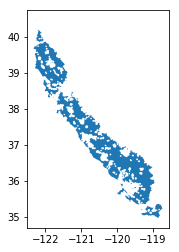

In [165]:
fin_df.plot()

In [ ]:
# shp to ee poly 

def gdf_to_ee_poly(gdf):
    t = gdf.geometry.simplify(0.1)
    lls = t.geometry.iloc[0]
    x,y = lls.exterior.coords.xy
    coords = [list(zip(x,y))]
    area = ee.Geometry.Polygon(coords)
    return area

cv = gp.read_file("../shape/cv.shp")
cv2 = cv.geometry.simplify(0.1)
lls = cv2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)
sa_km3 = round(cv2.area[0] * 10000, 2)